# A Julia é rápida

Frequentemente, programas são executados em diferentes linguagens de programação com o propósito de comparar os desempenhos das linguagens.
Esse tipo de comparação não é simples e pode gerar discussões.

Neste notebook vamos fazer uma comparação simples entre algumas linguagens de programação e deixar que você tire suas próprias conclusões.

## A função soma

Consideramos a função soma, denotada por `sum`, que é definida por
$$
\mathrm{sum}(a) = \sum_{j=1}^n a_j,
$$
onde $a = [a_1, a_2, \dots, a_j]$ é uma lista com $n$ elementos.

Vamos criar uma lista com 10<sup>7</sup> elementos escolhidos aleatoriamente no intervalo $[0,1]$:

In [1]:
a = rand(10^7)

10000000-element Vector{Float64}:
 0.5299975211076093
 0.7625377622012381
 0.7704270607367267
 0.42511941543369236
 0.46681905382781386
 0.93532872770659
 0.7613686350817828
 0.12797117754852105
 0.4879171978112178
 0.18058465205049523
 0.14691561571044787
 0.024595831469867102
 0.14791167702764163
 ⋮
 0.39021094199689
 0.24665910176904848
 0.0075942384106308936
 0.3367382777489123
 0.65667636733552
 0.8231262464711173
 0.8483460816095763
 0.3447000289066844
 0.5997668381781018
 0.7979068860393965
 0.14877740673747697
 0.09018118048747081

Calculamos a soma dos elementos de `a`:

In [2]:
sum(a)

4.9995590596976075e6

O resultado esperado é 0.5 * 10<sup>7</sup>, pois o valor médio de cada elemento da lista é igual a 0.5.

## Medindo desempenho de formas diferentes, em linguagens diferentes

In [3]:
@time sum(a)

  0.004752 seconds (1 allocation: 16 bytes)


4.9995590596976075e6

A macro `@time` é boa para uma estimativa grosseira, mas não é muito precisa.

O pacote `BenchmarkTools.jl` fornece um método simples e preciso de fazer comparações.

In [4]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/projects/julia-breve-intro/Project.toml`
  No Changes to `~/projects/julia-breve-intro/Manifest.toml`


In [5]:
using BenchmarkTools

## 1. C

A linguagem C é considerada uma linguagem difícil para os humanos e simples para as máquinas.

Em uma sessão da Julia, podemos inserir um programa em C, compilá-lo e executá-lo:

In [6]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()  # Cria um arquivo temporário

# Compila para uma biblioteca compartilhada passando
# o código C_code para o compilador gcc (só funciona
# se o gcc estiver instalado):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# Define uma função em Julia que chama a função do C
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [7]:
c_sum(a)

4.99955905969744e6

In [8]:
c_sum(a) ≈ sum(a)  # Digite \approx e tecle <TAB> para obter o símbolo ≈

true

In [9]:
c_sum(a) - sum(a)

-1.6763806343078613e-7

In [10]:
≈ # é uma abreviação (alias) para a função `isapprox`

isapprox (generic function with 9 methods)

In [11]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.


Agora podemos medir o desempenho do código C diretamente da sessão Julia.

In [12]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     8.568 ms (0.00% GC)
  median time:      8.587 ms (0.00% GC)
  mean time:        8.587 ms (0.00% GC)
  maximum time:     8.620 ms (0.00% GC)
  --------------
  samples:          583
  evals/sample:     1

In [13]:
println("C: O tempo mais rápido foi $(minimum(c_bench.times) / 1e6) msec")

C: O tempo mais rápido foi 8.567903 msec


In [14]:
d = Dict()
d["C"] = minimum(c_bench.times) / 1e6  # em milisegundos
d

Dict{Any, Any} with 1 entry:
  "C" => 8.5679

In [15]:
using Plots
gr()

Plots.GRBackend()

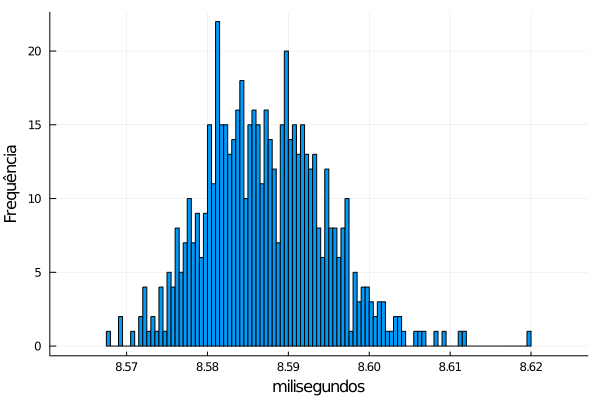

In [16]:
using Statistics
t = c_bench.times / 1e6 # tempos em milisegundos
m, σ = minimum(t), std(t)

histogram(t, bins=100,
    xlim=(m - σ, m + 8σ),
    xlabel="milisegundos", ylabel="Frequência", label="")

## 2. C com -ffast-math

Agora, vamos permitir que o C otimize suas operações de ponto flutuante.
Dessa forma, ele vai vetorizar suas instruções usando [SIMD](https://en.wikipedia.org/wiki/SIMD) (single instruction, multiple data).

In [17]:
const Clib_fastmath = tempname()

# Como acima mas agora com a opção -ffast-math
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# Define uma função em Julia que chama a função em C
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [18]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.980 ms (0.00% GC)
  median time:      5.027 ms (0.00% GC)
  mean time:        5.027 ms (0.00% GC)
  maximum time:     5.276 ms (0.00% GC)
  --------------
  samples:          995
  evals/sample:     1

In [19]:
d["C com -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # em milisegundos

4.97973

## 3. Python

O pacote `PyCall` fornece uma interface entre a Julia e o Python:

In [20]:
Pkg.add("PyCall")

   Resolving package versions...
  No Changes to `~/projects/julia-breve-intro/Project.toml`
  No Changes to `~/projects/julia-breve-intro/Manifest.toml`


In [21]:
using PyCall

In [22]:
# Importa a função "sum" do Python
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [23]:
pysum(a)

4.99955905969744e6

In [24]:
pysum(a) ≈ sum(a)

true

In [25]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     818.794 ms (0.00% GC)
  median time:      839.872 ms (0.00% GC)
  mean time:        834.918 ms (0.00% GC)
  maximum time:     841.349 ms (0.00% GC)
  --------------
  samples:          6
  evals/sample:     1

In [26]:
d["Python"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C com -ffast-math" => 4.97973
  "C"                 => 8.5679
  "Python"            => 818.794

## 4. Python `numpy`

A biblioteca `numpy` do Python é escrita em C e também utiliza SIMD.
Essa biblioteca pode ser instalada na Julia da seguinte forma:

In [27]:
Pkg.add("Conda")

   Resolving package versions...
  No Changes to `~/projects/julia-breve-intro/Project.toml`
  No Changes to `~/projects/julia-breve-intro/Manifest.toml`


In [28]:
using Conda

In [29]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     3.830 ms (0.00% GC)
  median time:      3.855 ms (0.00% GC)
  mean time:        3.857 ms (0.00% GC)
  maximum time:     4.300 ms (0.00% GC)
  --------------
  samples:          1295
  evals/sample:     1

In [30]:
numpy_sum(a)

4.999559059697596e6

In [31]:
numpy_sum(a) ≈ sum(a)

true

In [32]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C com -ffast-math" => 4.97973
  "C"                 => 8.5679
  "Python numpy"      => 3.82996
  "Python"            => 818.794

## 5. Python (escrito à mão)

In [33]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f18584ca4c0>

In [34]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     943.844 ms (0.00% GC)
  median time:      952.477 ms (0.00% GC)
  mean time:        956.468 ms (0.00% GC)
  maximum time:     988.484 ms (0.00% GC)
  --------------
  samples:          6
  evals/sample:     1

In [35]:
sum_py(a)

4.99955905969744e6

In [36]:
sum_py(a) ≈ sum(a)

true

In [37]:
d["Python escrito à mão"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C com -ffast-math"    => 4.97973
  "Python escrito à mão" => 943.844
  "C"                    => 8.5679
  "Python numpy"         => 3.82996
  "Python"               => 818.794

## 6. Julia

Em Julia, a função `sum` é escrita em Julia, não em C.

In [38]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [39]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.743 ms (0.00% GC)
  median time:      3.759 ms (0.00% GC)
  mean time:        3.766 ms (0.00% GC)
  maximum time:     4.315 ms (0.00% GC)
  --------------
  samples:          1327
  evals/sample:     1

In [40]:
d["Julia"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C com -ffast-math"    => 4.97973
  "Python escrito à mão" => 943.844
  "C"                    => 8.5679
  "Python numpy"         => 3.82996
  "Julia"                => 3.7429
  "Python"               => 818.794

## 7. Julia (escrito à mão)

In [41]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [42]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     8.655 ms (0.00% GC)
  median time:      8.737 ms (0.00% GC)
  mean time:        8.738 ms (0.00% GC)
  maximum time:     8.789 ms (0.00% GC)
  --------------
  samples:          573
  evals/sample:     1

In [43]:
d["Julia escrito à mão"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C com -ffast-math"    => 4.97973
  "Python escrito à mão" => 943.844
  "C"                    => 8.5679
  "Python numpy"         => 3.82996
  "Julia escrito à mão"  => 8.6548
  "Julia"                => 3.7429
  "Python"               => 818.794

## 8. Julia (escrito à mão com SIMD)

In [44]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [45]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.643 ms (0.00% GC)
  median time:      3.658 ms (0.00% GC)
  mean time:        3.659 ms (0.00% GC)
  maximum time:     3.793 ms (0.00% GC)
  --------------
  samples:          1366
  evals/sample:     1

In [46]:
mysum_simd(a)

4.99955905969753e6

In [47]:
d["Julia escrito à mão com SIMD"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia escrito à mão com SIMD" => 3.6428
  "C com -ffast-math"            => 4.97973
  "Python escrito à mão"         => 943.844
  "C"                            => 8.5679
  "Python numpy"                 => 3.82996
  "Julia escrito à mão"          => 8.6548
  "Julia"                        => 3.7429
  "Python"                       => 818.794

## Em resumo

In [48]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 30, "."), lpad(round(value; digits=2), 6, "."))
end

Julia escrito à mão com SIMD....3.64
Julia...........................3.74
Python numpy....................3.83
C com -ffast-math...............4.98
C...............................8.57
Julia escrito à mão.............8.65
Python........................818.79
Python escrito à mão..........943.84
